In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import HDBSCAN, KMeans
import igraph as ig

from sklearn.metrics import normalized_mutual_info_score

from karateclub import FeatherGraph, Graph2Vec

import json
from utils.graph_utils import get_all_user_graphs, get_all_sentiment_user_graphs, get_all_twitter_user_graphs

In [2]:
# Seaborn settings
sns.set_theme(style="whitegrid")        # Clean grid for academic style

# General settings
scale = 0.9
plt.rcParams.update({
#   'text.usetex': True,                # Use LaTeX for all text
    'figure.figsize': (6 * scale, 4 * scale),           # Default figure size
    'figure.autolayout': True,          # Tight layout
    'font.family': 'serif',             # Serif font (default for LaTeX)
    'font.size': 10,                    # Font size
    'axes.titlesize': 11,               # Title size
    'axes.labelsize': 10,               # Axis label size
    'legend.fontsize': 8,               # Legend font size
    'xtick.labelsize': 8,               # Tick label size
    'ytick.labelsize': 8,               # Tick label size
    'figure.dpi': 300,                  # High resolution
    'savefig.dpi': 300,                 # Save figures with high resolution
    'savefig.format': 'pgf',            # Default save format
    #'axes.linewidth': 0.75,             # Line width for axes
    #'legend.frameon': True,             # Remove legend frame
    #'legend.framealpha': 1,             # Legend opacity
})


In [3]:
graphs = get_all_sentiment_user_graphs()
graphs = [g.components(mode='weak').giant() for g in graphs]
graphs_nx = [g.simplify().to_networkx() for g in graphs]

categories = [g['category'] for g in graphs]
names = [g['name'] for g in graphs]

### Graph2Vec

In [4]:
model = Graph2Vec(workers=1, seed=42)
model.fit(graphs_nx)
g2v_embs = model.get_embedding()
pca = PCA(n_components=2)
g2v_embs_pca = pca.fit_transform(g2v_embs)
g2v_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(g2v_embs)
print(pca.explained_variance_ratio_)

/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[0.868281   0.09117673]


In [5]:
hdbscan = HDBSCAN()
hdbscan.fit(g2v_embs)
g2v_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, g2v_labels) if label != -1], 
    [label for label in g2v_labels if label != -1])
num_no_cluster = len([label for label in g2v_labels if label == -1])
print(nmi, num_no_cluster)

0.05392654131978827 12


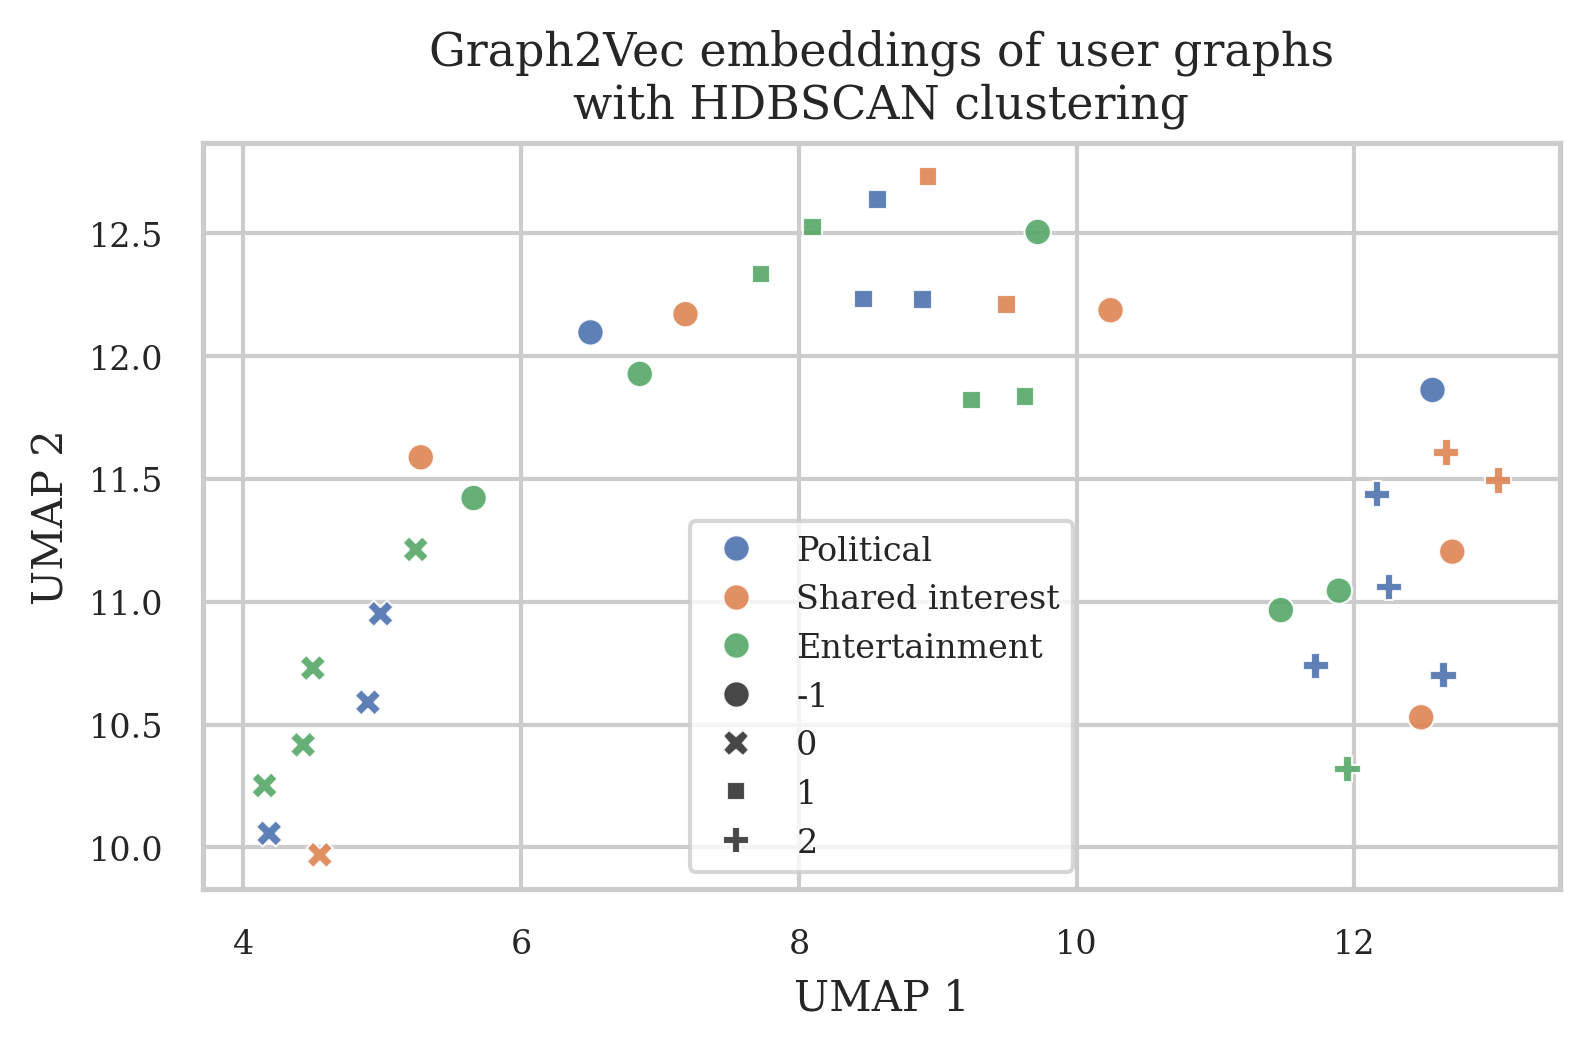

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, style=g2v_labels, s=40, alpha=0.9, ax=ax)
ax.set_title('Graph2Vec embeddings of user graphs\nwith HDBSCAN clustering')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/graph2vec.pgf', format='pgf', bbox_inches='tight')

### Subgraph embeddings

In [7]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/lcc.json'))

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
m_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
m_embs_pca = pca.fit_transform(m_embs)
m_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(m_embs)
print(pca.explained_variance_ratio_)

[0.78926539 0.07326133]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
hdbscan = HDBSCAN()
hdbscan.fit(m_embs)
m_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, m_labels) if label != -1], 
    [label for label in m_labels if label != -1])
num_no_cluster = len([label for label in m_labels if label == -1])
print(nmi, num_no_cluster)

0.0008139742996185118 1


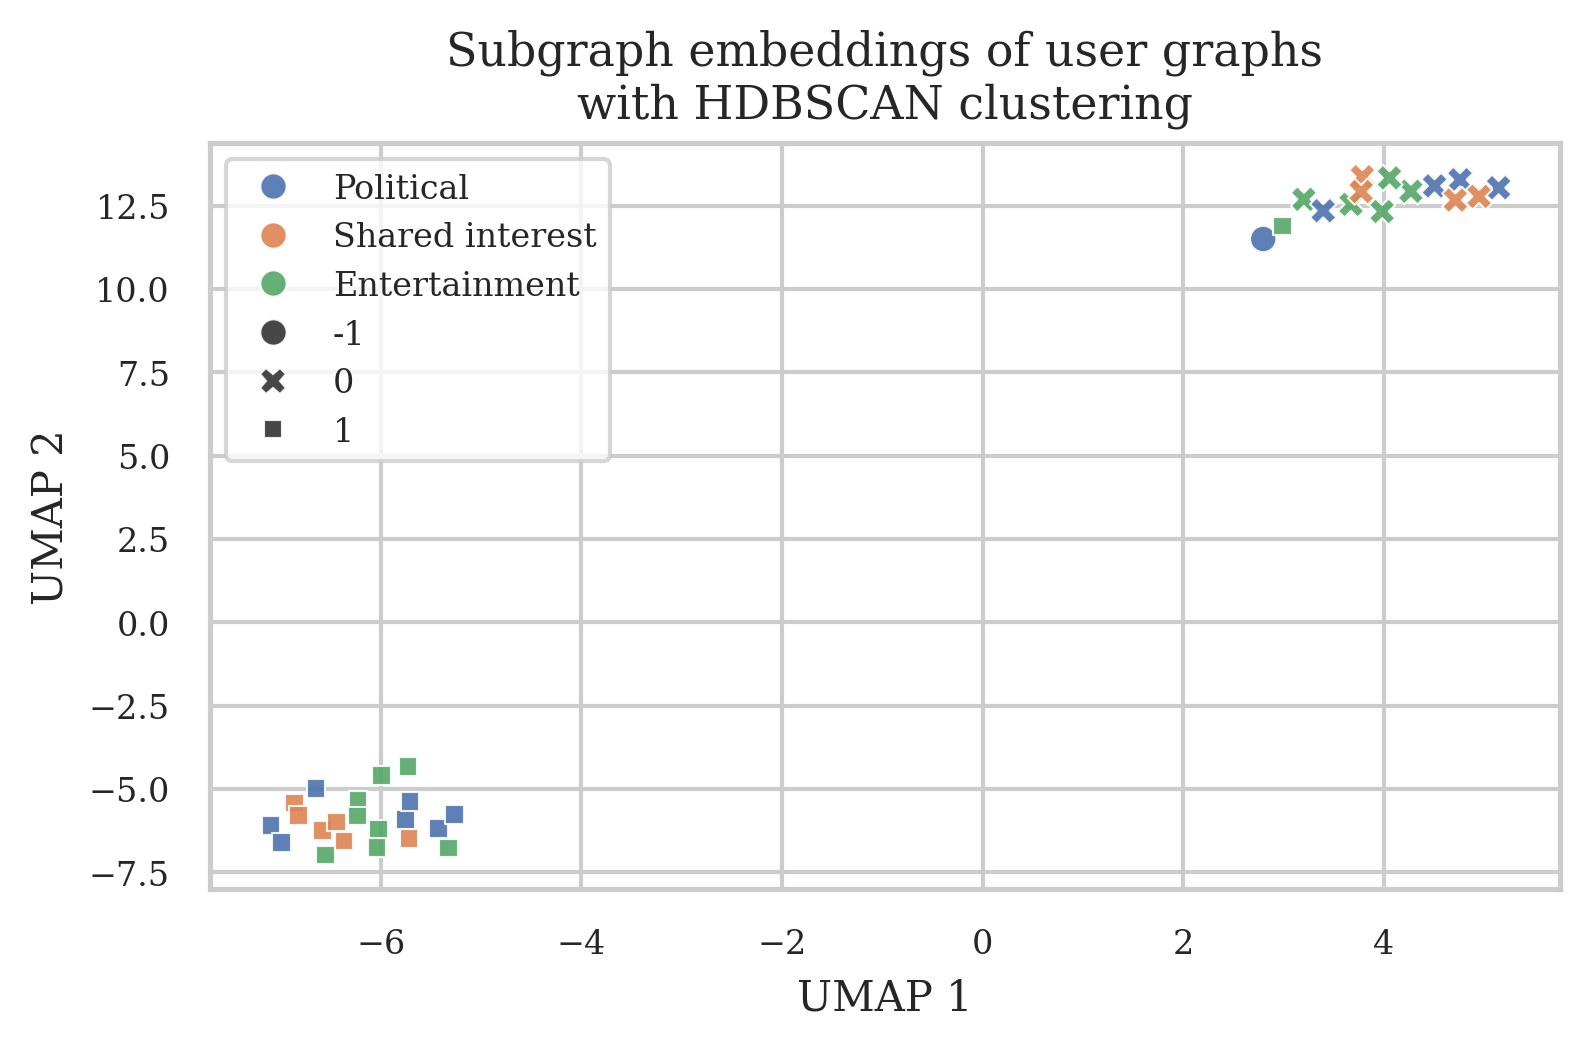

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, style=m_labels, s=40, alpha=0.9, ax=ax)
ax.set_title('Subgraph embeddings of user graphs\nwith HDBSCAN clustering')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/subgraph.pgf', format='pgf', bbox_inches='tight')

### Directed subgraph embeddings

In [10]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/lcc_directed.json'))

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
dm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
dm_embs_pca = pca.fit_transform(dm_embs)
dm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(dm_embs)
print(pca.explained_variance_ratio_)

[0.63086887 0.12634118]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
hdbscan = HDBSCAN()
hdbscan.fit(dm_embs)
dm_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, dm_labels) if label != -1], 
    [label for label in dm_labels if label != -1])
num_no_cluster = len([label for label in dm_labels if label == -1])
print(nmi, num_no_cluster)

0.022739237565347677 2


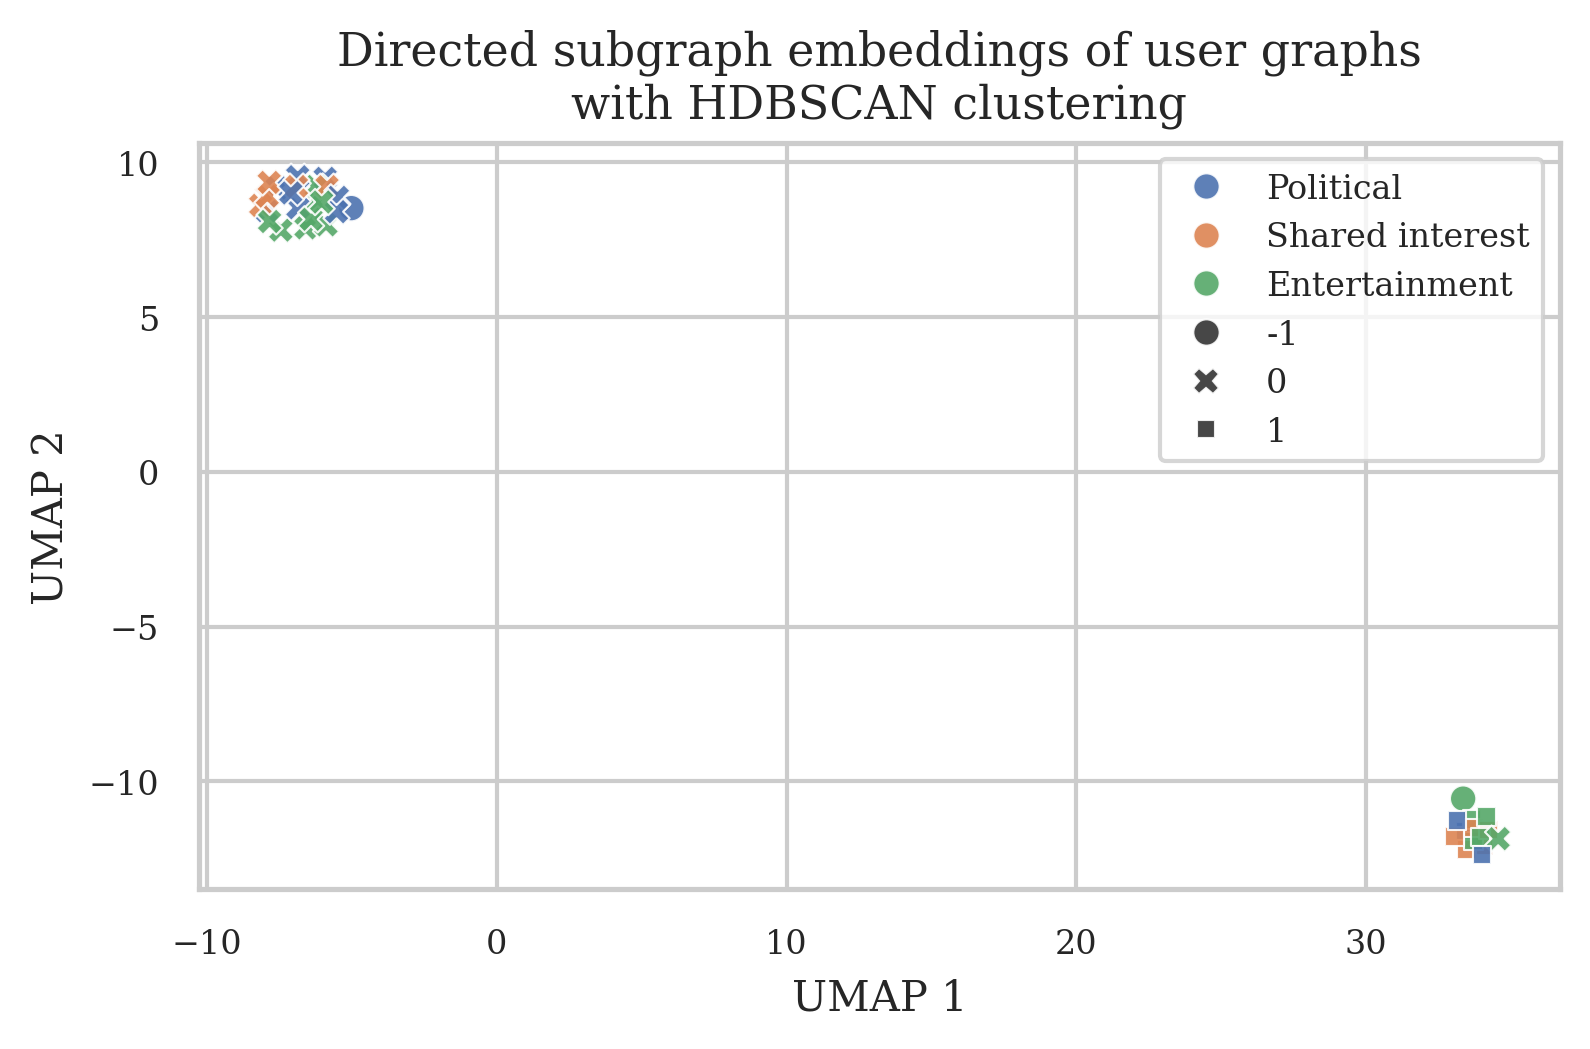

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(x=dm_embs_umap[:, 0], y=dm_embs_umap[:, 1], hue=categories, style=dm_labels, s=40, alpha=0.9, ax=ax)
ax.set_title('Directed subgraph embeddings of user graphs\nwith HDBSCAN clustering')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/directed_subgraph.pgf', format='pgf', bbox_inches='tight')

### Sentiment subgraph embeddings

In [13]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc.json'))

subgraph_data = [subgraph for subgraph in subgraph_data if 3 not in subgraph['edge_colors']]

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
sm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
sm_embs_pca = pca.fit_transform(sm_embs)
sm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(sm_embs)
print(pca.explained_variance_ratio_)

[0.75940558 0.07045146]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
hdbscan = HDBSCAN()
hdbscan.fit(sm_embs)
sm_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, sm_labels) if label != -1], 
    [label for label in sm_labels if label != -1])
num_no_cluster = len([label for label in sm_labels if label == -1])
print(nmi, num_no_cluster)

0.039324240836315145 2


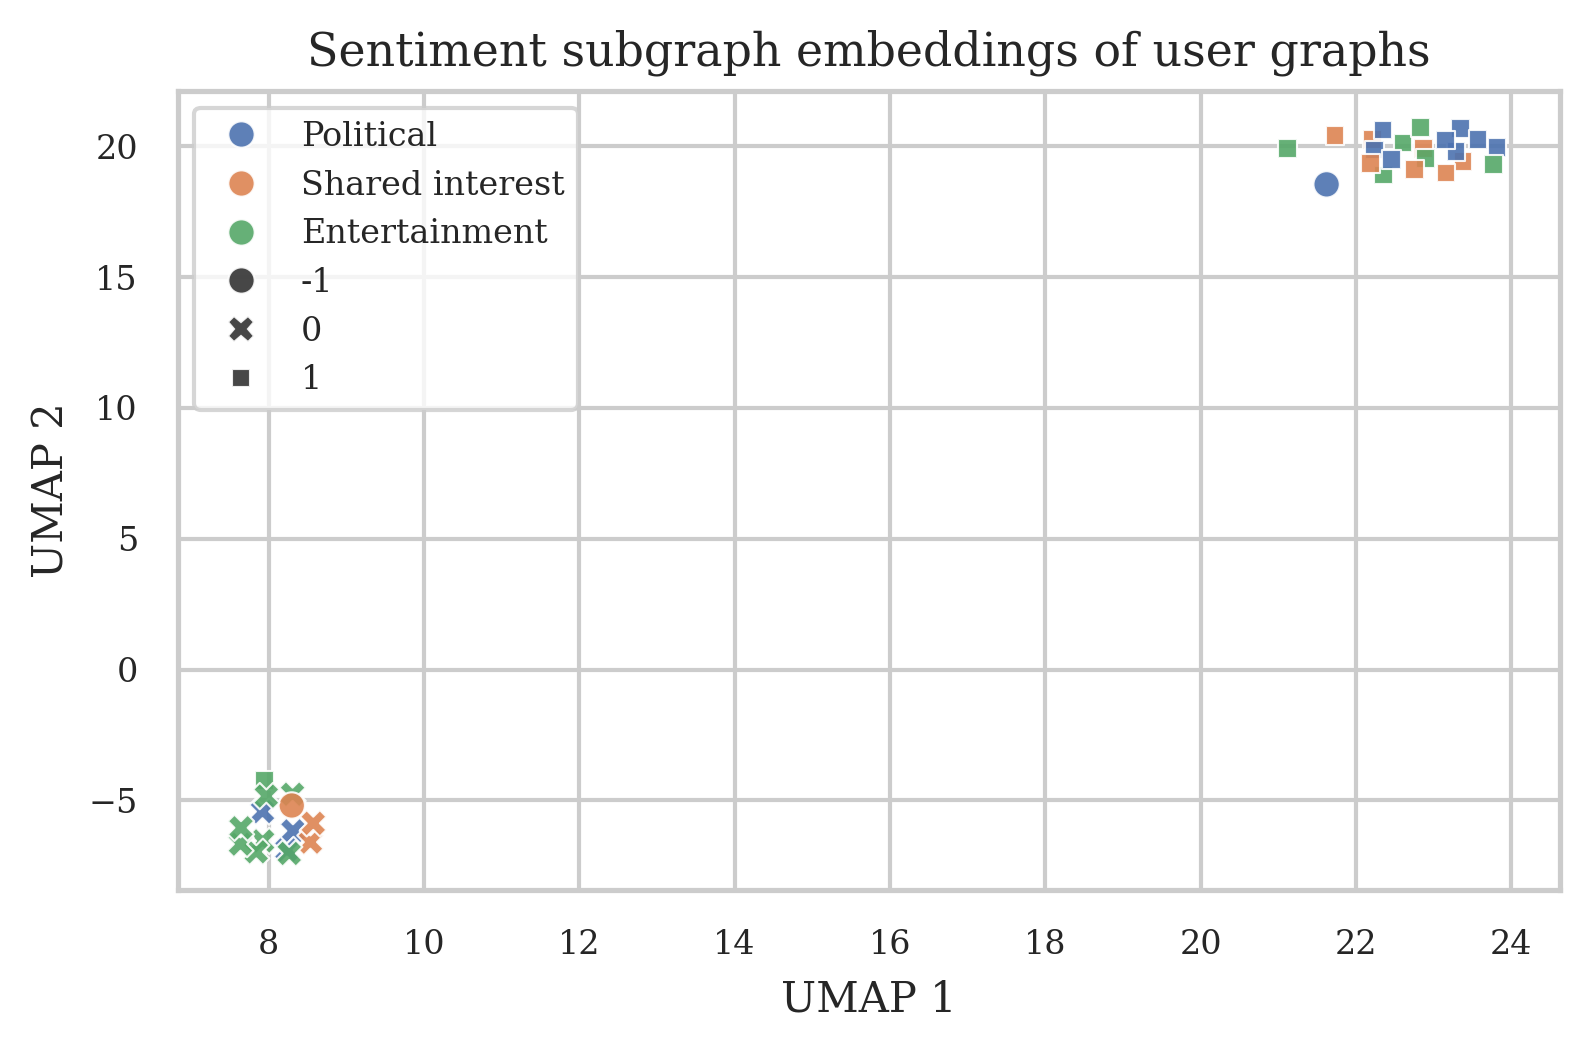

In [15]:
fig, ax = plt.subplots()
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, style=sm_labels, s=40, alpha=.9, ax=ax)
ax.set_title('Sentiment subgraph embeddings of user graphs')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/sentiment_subgraph.pgf', format='pgf', bbox_inches='tight')

### Directed sentiment subgraph embeddings

In [16]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc_directed.json'))

# extract motif matrix
subgraph_matrix = [subgraph['graph_occurrences'] for subgraph in subgraph_data]
dsm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
embs_pca = pca.fit_transform(dsm_embs)
dsm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(dsm_embs)
print(pca.explained_variance_ratio_)

[0.59622796 0.08235174]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
hdbscan = HDBSCAN()
hdbscan.fit(dsm_embs)
dsm_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, dsm_labels) if label != -1], 
    [label for label in dsm_labels if label != -1])
num_no_cluster = len([label for label in dsm_labels if label == -1])
print(nmi, num_no_cluster)

0.042125300490379214 3


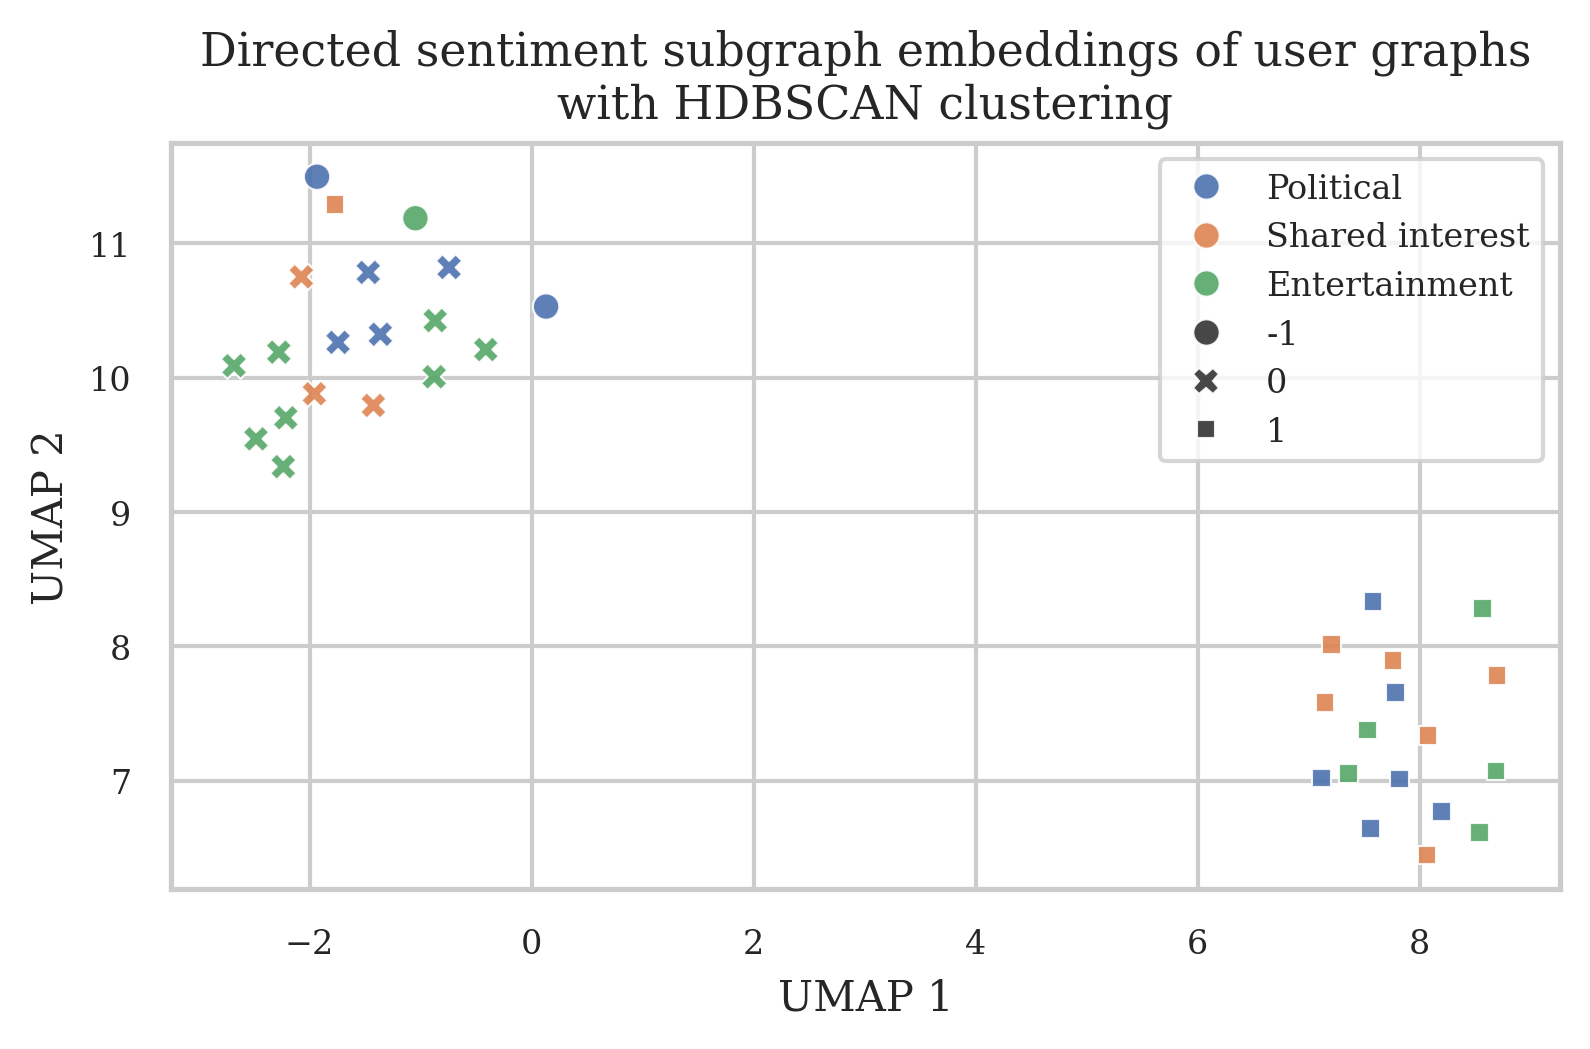

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(x=dsm_embs_umap[:, 0], y=dsm_embs_umap[:, 1], hue=categories, style=dsm_labels, s=40, alpha=.9, ax=ax)
ax.set_title('Directed sentiment subgraph embeddings of user graphs\nwith HDBSCAN clustering')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/sentiment_subgraph_directed.pgf', format='pgf', bbox_inches='tight')

### Super figure

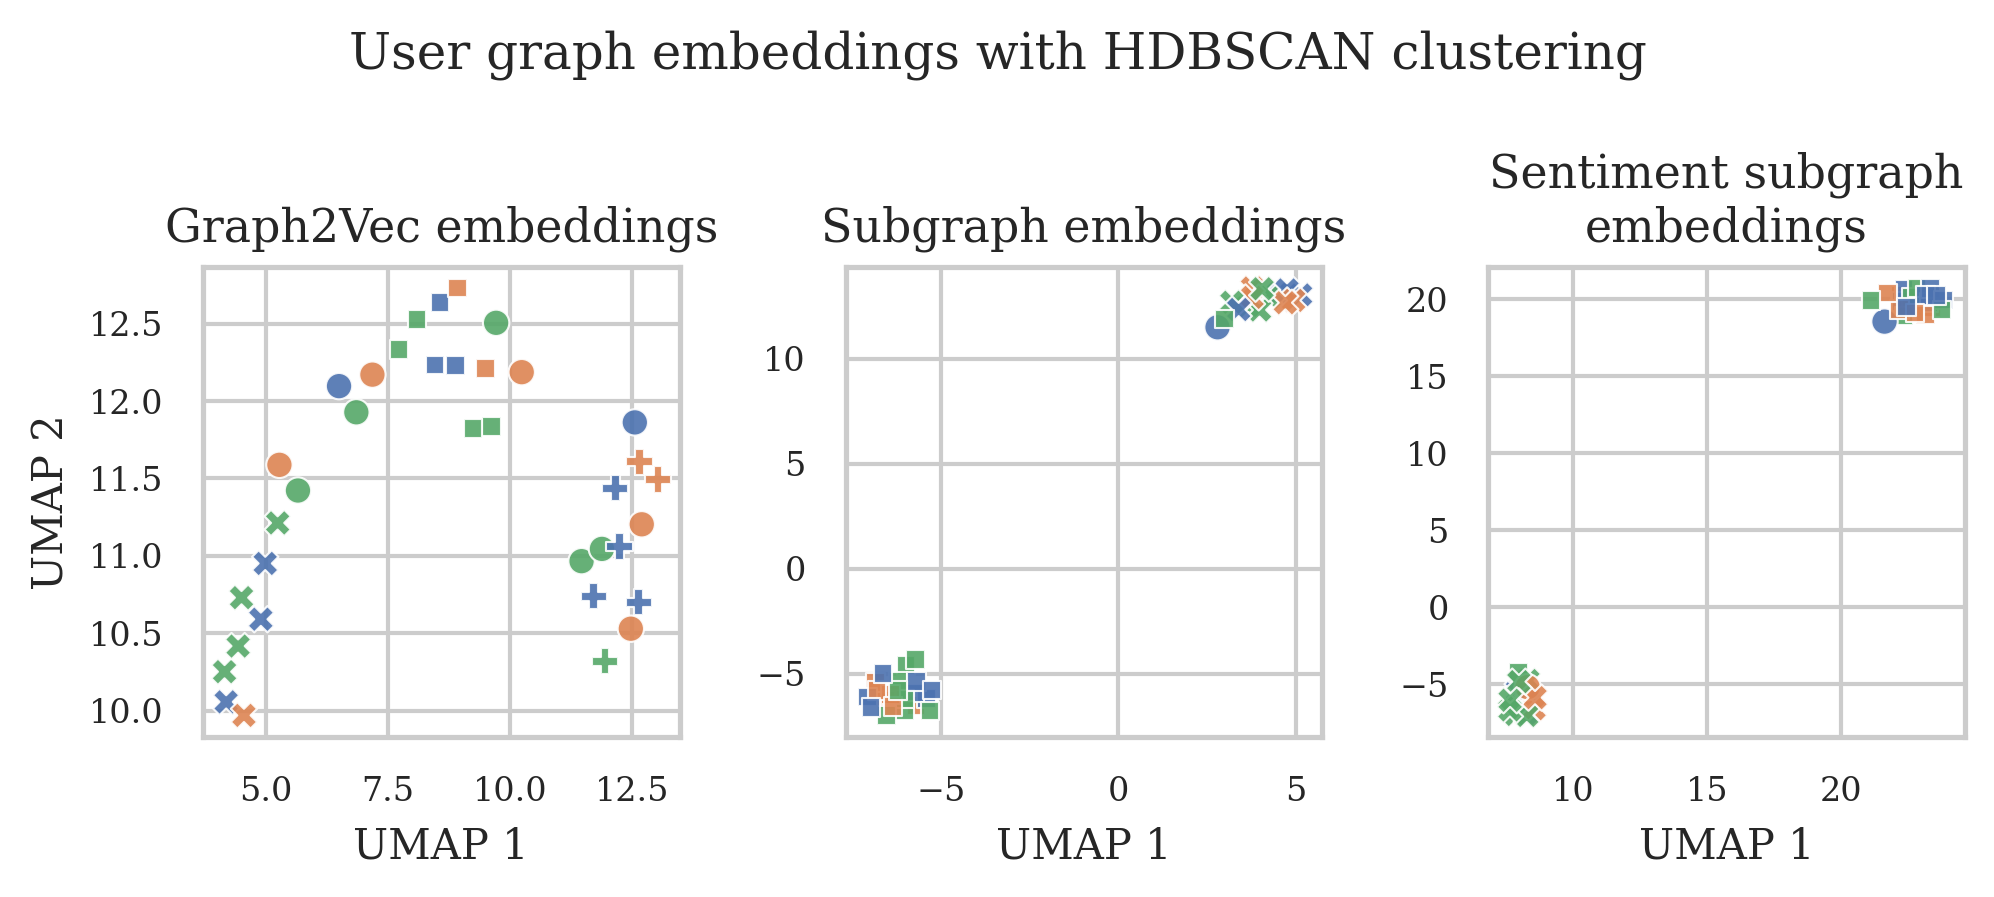

In [19]:
scale = 0.75
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6*scale*1.5, 4*scale))
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, style=g2v_labels, s=40, alpha=0.9, ax=ax1)
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, style=m_labels, s=40, alpha=0.9, legend=False, ax=ax2)
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, style=sm_labels, s=40, alpha=0.9, legend=False, ax=ax3)
fig.suptitle('User graph embeddings with HDBSCAN clustering')
ax1.set_title('Graph2Vec embeddings')
ax2.set_title('Subgraph embeddings')
ax3.set_title('Sentiment subgraph\nembeddings')

ax1.set_ylabel('UMAP 2')
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('UMAP 1')
    
legend = ax1.get_legend()
ax1.legend_.remove()

plt.tight_layout()
plt.savefig('../figures/embeddings/embeddings_comparison.pgf', format='pgf', bbox_inches='tight')

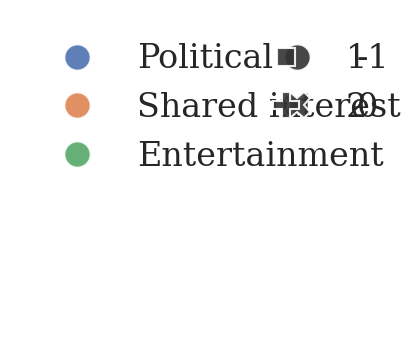

In [20]:
# https://gist.github.com/rldotai/012dbb3294bb2599ff82e61e82356990
fig.canvas.draw()
legend_bbox = legend.get_tightbbox(fig.canvas.get_renderer())
legend_bbox = legend_bbox.transformed(fig.dpi_scale_trans.inverted())

legend_fig, legend_ax = plt.subplots(figsize=(legend_bbox.width, legend_bbox.height))

legend_squared = legend_ax.legend(
    *ax1.get_legend_handles_labels(), 
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=legend_fig.transFigure,
    frameon=False,
    fancybox=None,
    shadow=False,
    ncol=3,
    mode='expand',
)

legend_ax.axis('off')
plt.savefig('../figures/embeddings/legend.pgf', format='pgf', bbox_inches='tight')

### FeatherGraph

In [21]:
model = FeatherGraph()
model.fit(graphs_nx)
fg_embs = model.get_embedding()
pca = PCA(n_components=2)
fg_embs_pca = pca.fit_transform(fg_embs)
fg_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(fg_embs)
print(pca.explained_variance_ratio_)

[0.38161885 0.27791998]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
hdbscan = HDBSCAN(alpha=0.5)
hdbscan.fit(fg_embs)
fg_labels = hdbscan.labels_
nmi = normalized_mutual_info_score(
    [category for category, label in zip(categories, fg_labels) if label != -1], 
    [label for label in fg_labels if label != -1])
num_no_cluster = len([label for label in fg_labels if label == -1])
print(nmi, num_no_cluster)

0.19477329309254146 17


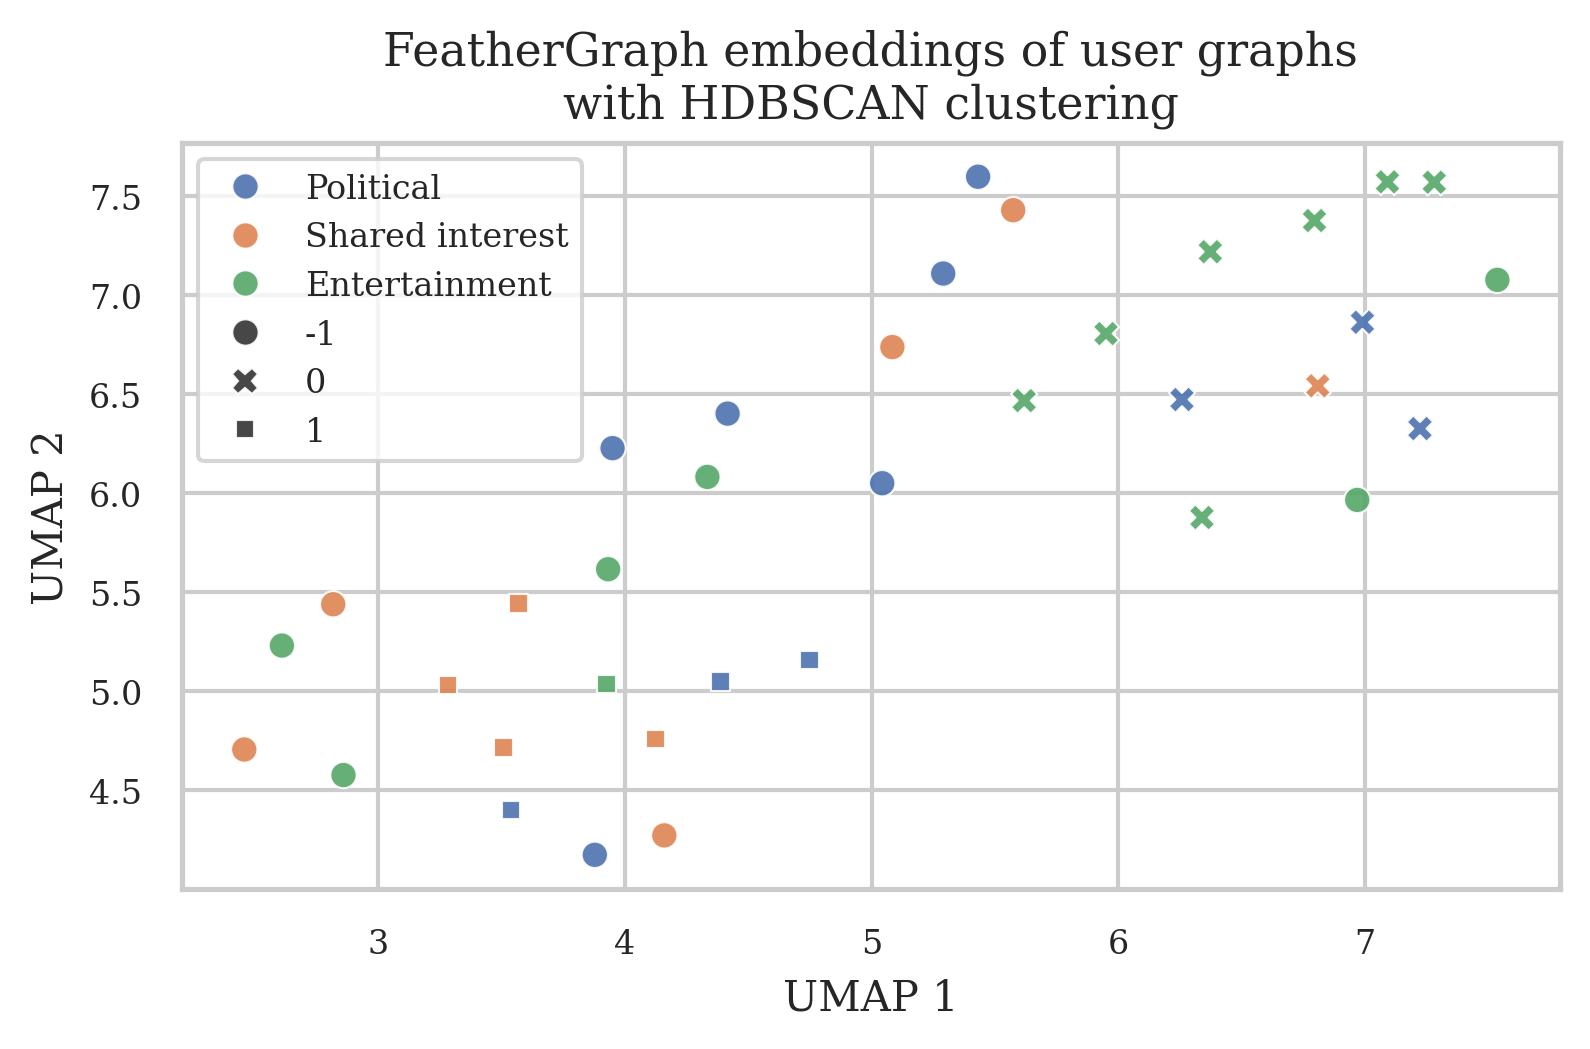

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x=fg_embs_umap[:, 0], y=fg_embs_umap[:, 1], hue=categories, style=fg_labels, s=40, alpha=.9, ax=ax)
ax.set_title('FeatherGraph embeddings of user graphs\nwith HDBSCAN clustering')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig('../figures/embeddings/feathergraph.pgf', format='pgf', bbox_inches='tight')

# Twitter magic

In [24]:
tiktok = get_all_sentiment_user_graphs()
twitter = get_all_twitter_user_graphs()
graphs = tiktok + twitter
graphs = [g.components(mode='weak').giant() for g in graphs]
graphs_nx = [g.simplify().to_networkx() for g in graphs]

categories = len(tiktok) * ['TikTok'] + len(twitter) * ['Twitter']
names = [g['name'] for g in graphs]

In [25]:
model = Graph2Vec(workers=1, seed=42)
model.fit(graphs_nx)
g2v_embs = model.get_embedding()
pca = PCA(n_components=2)
g2v_embs_pca = pca.fit_transform(g2v_embs)
g2v_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(g2v_embs)
print(pca.explained_variance_ratio_)

[0.7217796  0.13443492]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


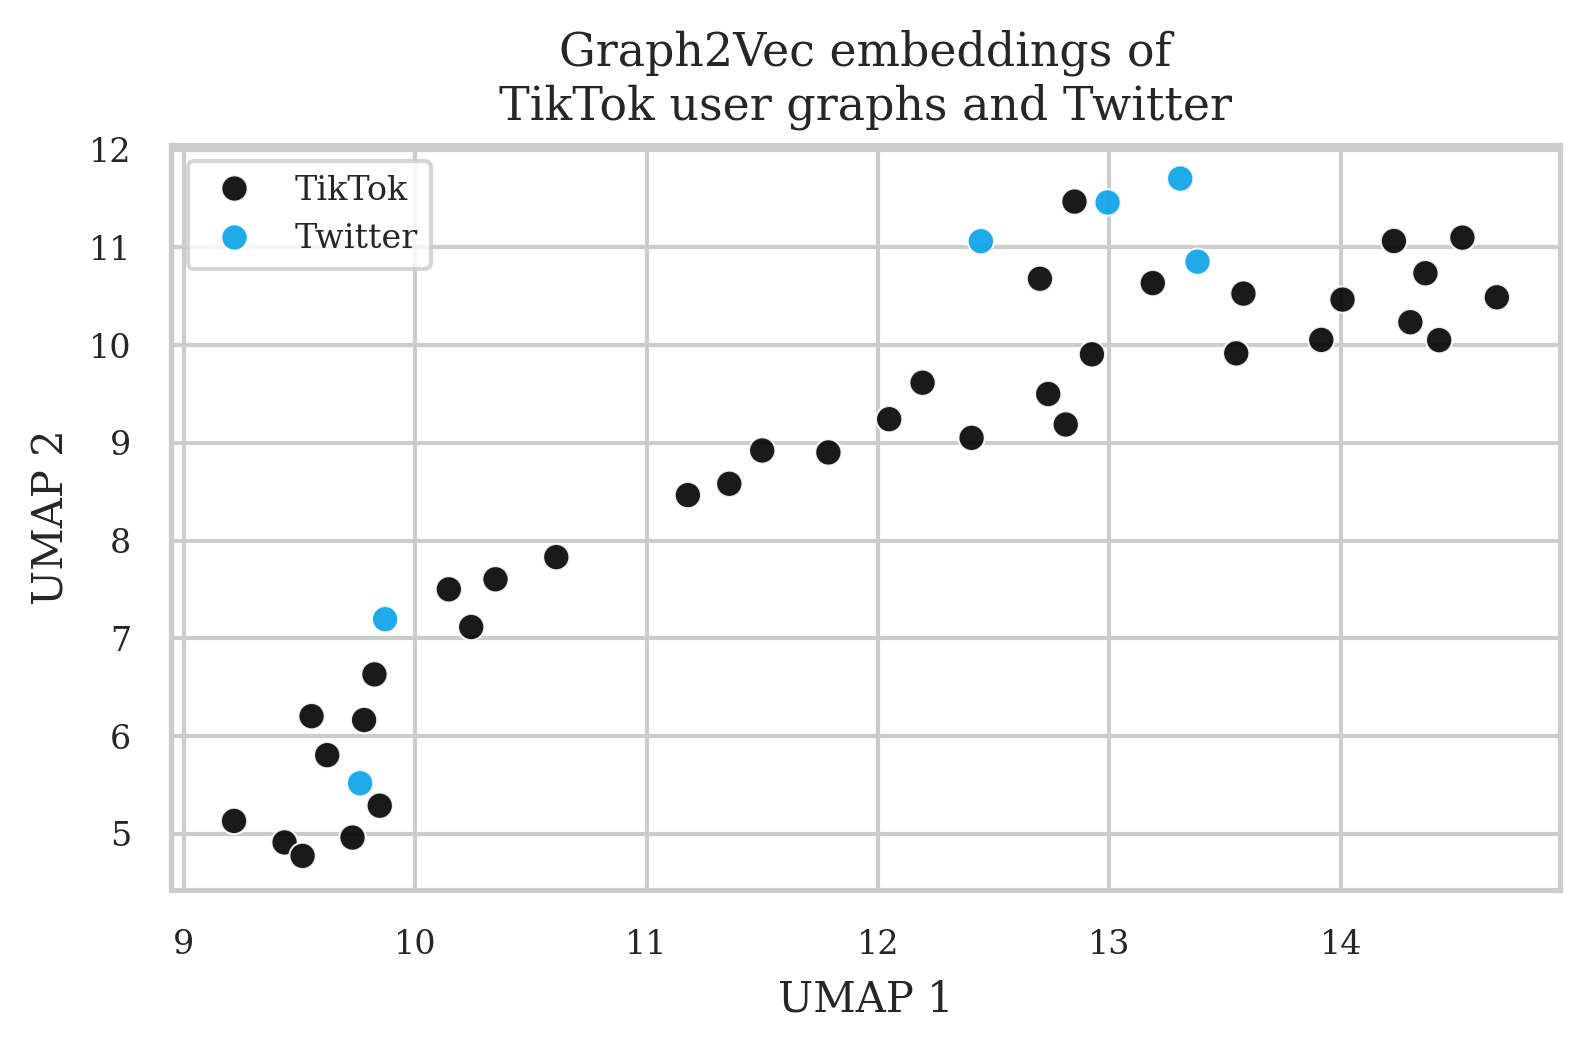

In [26]:
fig, ax = plt.subplots()
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Graph2Vec embeddings of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

In [27]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/lcc.json'))

# extract motif matrix
subgraph_matrix = np.concatenate((
    [subgraph['graph_occurrences'] for subgraph in subgraph_data],
    [subgraph['twitter_occurences'] for subgraph in subgraph_data]
), axis=1)
m_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
m_embs_pca = pca.fit_transform(m_embs)
m_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(m_embs)
print(pca.explained_variance_ratio_)

[0.79089999 0.07149393]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


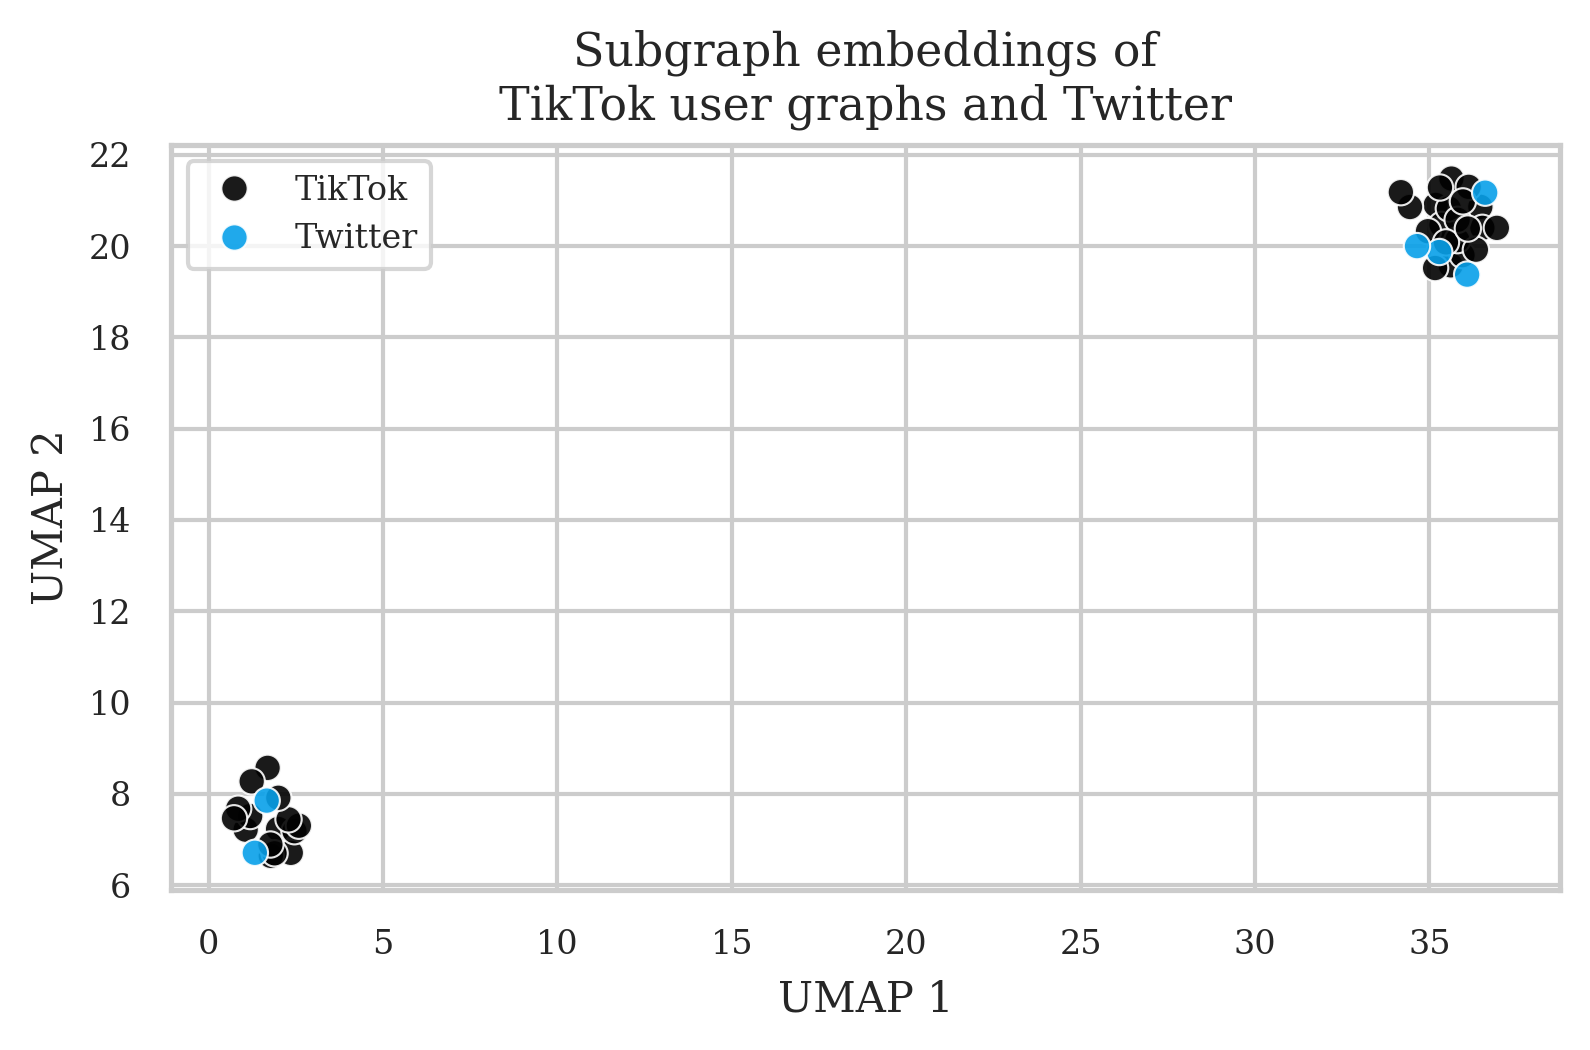

In [28]:
fig, ax = plt.subplots()
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Subgraph embeddings of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

In [29]:
subgraph_data = json.load(open('../data/fsm/subgraph_data/sentiment_lcc.json'))

# remove missing content subgraphs
subgraph_data = [subgraph for subgraph in subgraph_data if 3 not in subgraph['edge_colors']]

# extract motif matrix
subgraph_matrix = np.concatenate((
    [subgraph['graph_occurrences'] for subgraph in subgraph_data],
    [subgraph['twitter_occurences'] for subgraph in subgraph_data]
), axis=1)
sm_embs = np.array(subgraph_matrix, dtype=np.int32).T

pca = PCA(n_components=2)
sm_embs_pca = pca.fit_transform(sm_embs)
sm_embs_umap = UMAP(n_components=2, random_state=42).fit_transform(sm_embs)
print(pca.explained_variance_ratio_)

[0.76977807 0.06452051]


/home/mahf/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


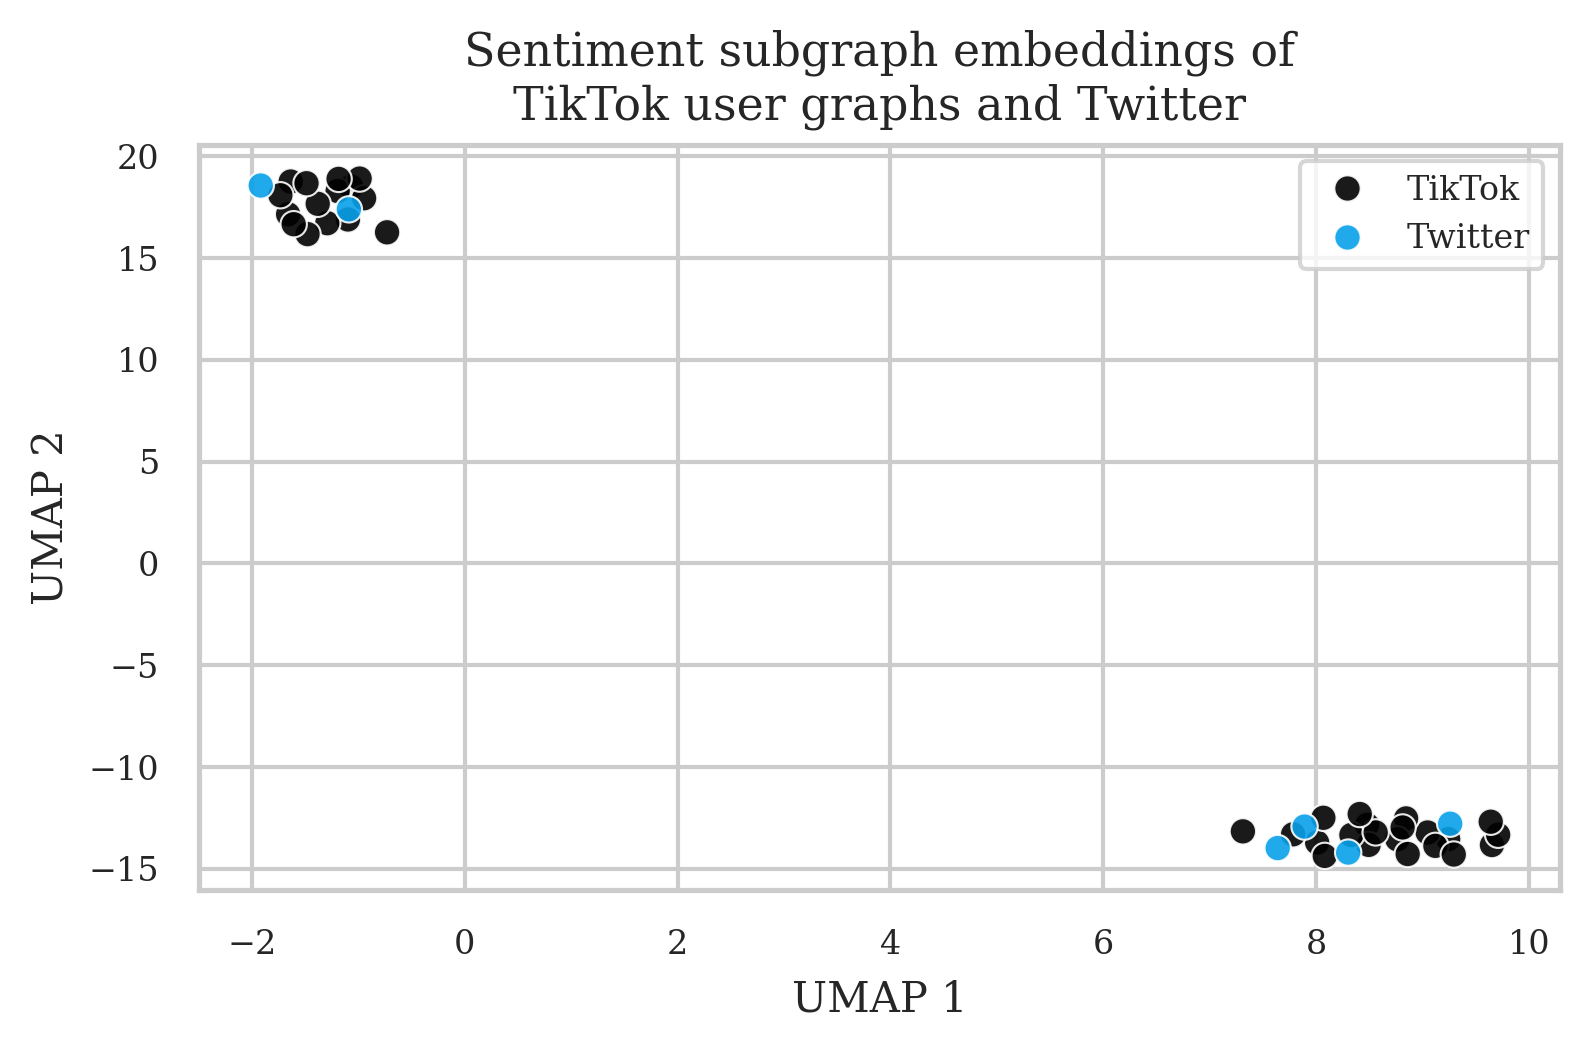

In [30]:
fig, ax = plt.subplots()
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'],s=40, alpha=0.9, ax=ax)
ax.set_title('Sentiment subgraph embeddings of\nTikTok user graphs and Twitter')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.tight_layout()

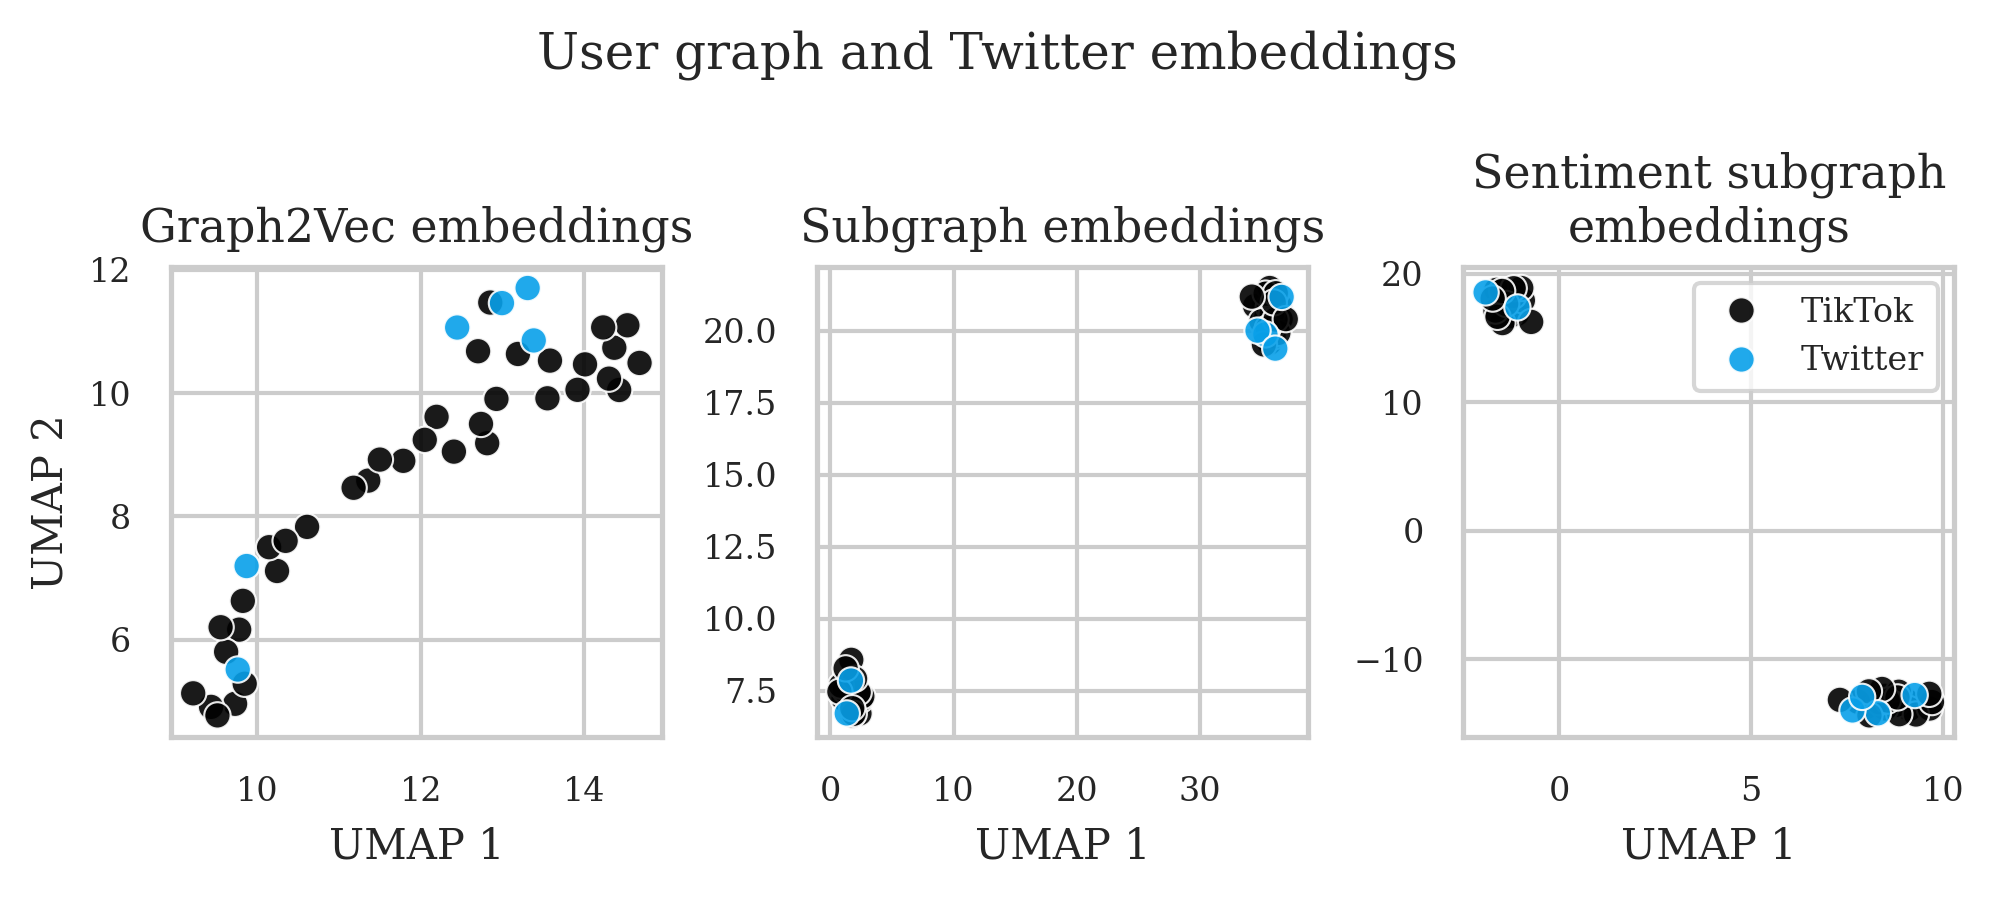

In [31]:
scale = 0.75
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6*scale*1.5, 4*scale))
sns.scatterplot(x=g2v_embs_umap[:, 0], y=g2v_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'], s=40, alpha=0.9, legend=False, ax=ax1)
sns.scatterplot(x=m_embs_umap[:, 0], y=m_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'], s=40, alpha=0.9, legend=False, ax=ax2)
sns.scatterplot(x=sm_embs_umap[:, 0], y=sm_embs_umap[:, 1], hue=categories, palette=['#010101', '#08a0e9'], s=40, alpha=0.9, ax=ax3)
fig.suptitle('User graph and Twitter embeddings')
ax1.set_title('Graph2Vec embeddings')
ax2.set_title('Subgraph embeddings')
ax3.set_title('Sentiment subgraph\nembeddings')

ax1.set_ylabel('UMAP 2')
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('UMAP 1')

plt.tight_layout()
plt.savefig('../figures/embeddings/twitter_comparison.pgf', format='pgf', bbox_inches='tight')